In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.finite_difference import DivergedError
from abtem.multislice import FourierMultislice, RealSpaceMultislice

abtem.config.set({"device": "cpu"});
abtem.config.set({"local_diagnostics.progress_bar": True});
abtem.config.set({"local_diagnostics.task_level_progress": False});

# Multislice using the real space algorithm

For certain kinds of situations, it is necessary to run the multislice algorithm fully in real space and not rely on Fourier transforms. This will incur a performance penalty, however, so this method is not used by default.

Let's demonstrate this for Si in the (110) orientation.

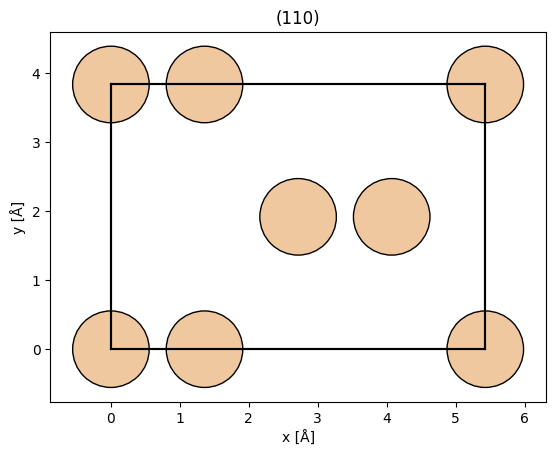

In [2]:
desired_rotation = 45
silicon = ase.build.bulk("Si", cubic=False)

# Rotates silicon structure by 45 degrees.
rotated_silicon = silicon.copy()

rotated_silicon.rotate(desired_rotation, "x", rotate_cell=True)
rotated_silicon, transform = abtem.orthogonalize_cell(
    rotated_silicon, max_repetitions=10, return_transform=True
)

rotated_silicon.center(axis=2)

abtem.show_atoms(
    rotated_silicon, show_periodic=True, scale=0.5, title="(110)", plane="xy"
);

Create a potential.

In [3]:
potential_unit = abtem.Potential(
    rotated_silicon,
    slice_thickness=0.5,
    sampling=0.05,
    projection="finite",
)
potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 10))
plane_wave = abtem.PlaneWave(energy=200e3)
plane_wave.grid.match(potential)

Simulations currently requires importing the `MultisliceTransform` object. You can set the order of the accuracy of the [finite difference derivative stencil](https://en.wikipedia.org/wiki/Finite_difference_coefficient) using the `derivative_accuracy` keyword. The total number of terms in the series expansion is determined by a convergence criteria.

In [5]:
exit_wave_cms = plane_wave.multislice(
    potential,
    algorithm=FourierMultislice(), # default, can omit
    lazy=False
)
exit_wave_rms = plane_wave.multislice(
    potential,
    algorithm=RealSpaceMultislice(),
    lazy=False
)

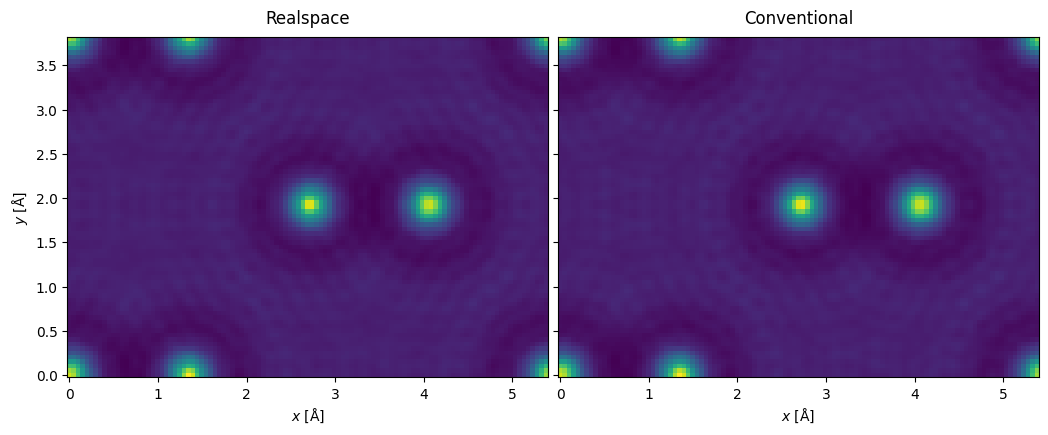

In [6]:
abtem.stack((exit_wave_rms, exit_wave_cms), ("Realspace", "Conventional")).show(
    explode=True, figsize=(12, 4)
);

The calculation may diverge if the slices are too thick, you can catch the `DivergedError` exception. A better sampling also requires a smaller slice thickness.

In [7]:
potential_unit = abtem.Potential(
    rotated_silicon,
    slice_thickness=2,
    sampling=0.05,
    projection="finite",
)

potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 10))
plane_wave = abtem.PlaneWave(energy=200e3)
plane_wave.grid.match(potential)

try:
    exit_wave_rms = plane_wave.multislice(
        potential,
        algorithm=RealSpaceMultislice(),
        lazy=False
    )
except DivergedError:
    print("calculation diverged")

calculation diverged
